In [89]:
import pynndescent
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# PyNNDescent

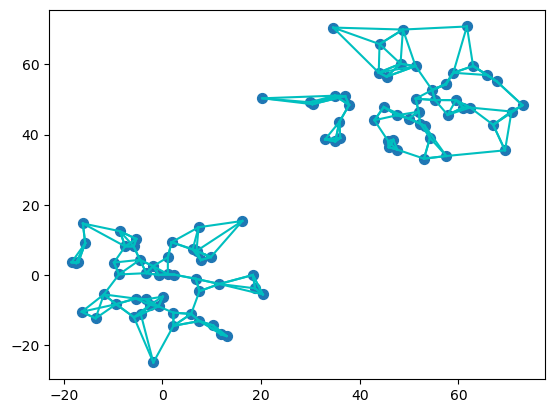

In [2]:
np.random.seed(100)
cluster = np.random.randn(100, 2)*10
cluster[50:, :] += 50

idx = pynndescent.NNDescent(cluster, n_neighbors=4)

adj = idx.neighbor_graph[0]

plt.scatter(cluster[:, 0], cluster[:, 1], s=50)
for row in adj:
    u = row[0]
    x1, y1 = cluster[u]
    for v in row[1:]:
        x2, y2 = cluster[v]
        plt.plot([x1, x2], [y1, y2], c='c')

## NSW

In [3]:
def get_nn(u, k):
    nodes = list(nsw)
    dist = []
    for v in nodes:
        dist.append(((cluster[u] - cluster[v])**2).sum())
    dist = np.argsort(dist)
    return [nodes[n] for n in dist[:k]]


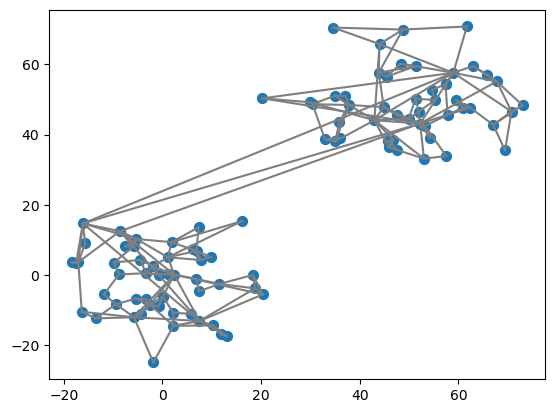

In [4]:
nsw = {}
plt.figure()
for j, u in enumerate(np.random.permutation(len(cluster))):
    nsw[u] = get_nn(u, 2)

    x, y = cluster[u]
    plt.scatter(x, y, s=50, c='C0')
    
    for v in nsw[u]:
        x1, y1 = cluster[v]
        plt.plot([x, x1], [y, y1], c='C7')
        
    plt.savefig(f'./images/nsw_{j}.png')

In [30]:
import imageio

In [31]:
images = []
for i in range(0, 100):
    images.append(imageio.imread(f'./images/nsw_{i}.png'))

imageio.mimsave('./images/nsw.gif', images, duration=.1)

In [32]:
sum(map(len, nsw.values()))*2/100

3.94

# HNSW

In [73]:

# https://github.com/pinecone-io/examples/blob/master/hnsw_faiss/hnsw_faiss.ipynb

def set_default_probas(M: int, m_L: float):
    nn = 0  # set nearest neighbors count = 0
    cum_nneighbor_per_level = []
    level = 0  # we start at level 0
    assign_probas = []
    while True:
        # calculate probability for current level
        proba = np.exp(-level / m_L) * (1 - np.exp(-1 / m_L))
        # once we reach low prob threshold, we've created enough levels
        if proba < 1e-2: break
        assign_probas.append(proba)
        # neighbors is == M on every level except level 0 where == M*2
        nn = M*2 if level == 0 else M
        cum_nneighbor_per_level.append(nn)
        level += 1
    return assign_probas, cum_nneighbor_per_level 

In [74]:
probas, nnbs = set_default_probas(2, 1/np.log(2))
probas, nnbs

([0.5, 0.25, 0.125, 0.06250000000000001, 0.03125, 0.015625],
 [4, 2, 2, 2, 2, 2])

In [76]:
probas = np.cumsum(probas)

probas[-1] = 1

probas

def random_label(probas):
    x = np.random.rand()
    for i in range(len(probas)):
        if x <= probas[i]:return i

In [77]:
layers = {i: random_label(probas) for i in range(len(cluster))}

In [78]:
nnbs

[4, 2, 2, 2, 2, 2]

In [79]:
graphs = [defaultdict(set) for i in range(len(nnbs))]

In [80]:
def get_nn(graph, u, k):
    nodes = list(graph)
    dist = []
    for v in nodes:
        dist.append(((cluster[u] - cluster[v])**2).sum())
    dist = np.argsort(dist)
    return [nodes[n] for n in dist[:k]]


In [87]:
num_layers = len(probas)
def get_ep():
    for graph in graphs[::-1]:
        if len(graph) > 0:
            return np.random.choice(list(graph))
    return None

def insert_node(u):
    layer = layers[u] # Sample the node layer for u
    ep = get_ep()
    if ep is not None:
        for l in range(ep_layer, layer, -1):
            ep = get_nn(graphs[l], ep, 1)
    print(ep)
        

In [88]:
# Pseudo Code
for node in nodes: # can be any order
    this_layer = sample_layer() # from geometric distribution
    ep = get_entry_point()
    
    for layer in range(L, this_layer, -1):
        ep = get_nn(graph_at[layer], ep, 1) # get nearest neighbour to this node in this layer
    
    for layer in range(min(L, this_layer), -1, -1):
        nbs = get_nn(graph_at[layer], node, efConstruction)
        for nb in nbs:
            graph_at[layer][node].add(nb)
            graph_at[layer][nb].add(node)
            trim(graph_at[layer][nb]) # if degree of nb > M, get the best M 
    

None
